<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Input-Representation" data-toc-modified-id="Input-Representation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Input Representation</a></span></li><li><span><a href="#Pretrained-BERT" data-toc-modified-id="Pretrained-BERT-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Pretrained BERT</a></span></li><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prepare Data</a></span></li><li><span><a href="#BERT-Tokenizer" data-toc-modified-id="BERT-Tokenizer-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>BERT Tokenizer</a></span></li><li><span><a href="#Train-data-generation" data-toc-modified-id="Train-data-generation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train data generation</a></span></li><li><span><a href="#Create-Classification-Model" data-toc-modified-id="Create-Classification-Model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Create Classification Model</a></span></li><li><span><a href="#Model-Train" data-toc-modified-id="Model-Train-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Model Train</a></span></li><li><span><a href="#Loss-Visualization" data-toc-modified-id="Loss-Visualization-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Loss Visualization</a></span></li><li><span><a href="#Model-Evaluation" data-toc-modified-id="Model-Evaluation-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Model Evaluation</a></span></li></ul></div>

## Input Representation

Bert의 Input Representation는 3가지 임베딩이 합쳐져 만들어진다.
- Token Embedding: Bert는 word piece embedding방식을 사용한다. (word piece embedding은 자주 등장하는 sub word 중 가장 긴 길이의 subword를 하나의 단위로 생성하는 것이다. rare word는 subword로 분리된다. 이러한 방식을 이용하면 OOV문제를 해결할 수 있다.)
- Sentence Embedding: Bert는 sperate token으로 구분된 두 문장을 입력으로 받는다. 이 두 문장은 512 이하의 subword를 가지도록 제한된다. (한국어는 일반적으로 한 문장당 20개의 subwords로 구성되며, 대부분의 경우 60 subword를 넘지 않는다. 그래서 두 문장을 합쳐 128 subword를 갖는다고 설정해도 문제가 없다. 입력길이가 128이 넘는 경우가 있다 해도 그것들에 대해 따로 추가 학습을 해줄 수 있다.
- Position Embedding: Bert도 Transformer과 마찬가지로 RNN계열의 모델을 기반으로 하지 않기 때문에 위치정보를 따로 주어야 한다. Bert는 Transformer에서 사용된 positional encoding을 조금 변형한 position embedding을 사용한다. 

위 3가지 Embedding을 합쳐서 나온 결과를 normalization, dropout해서 Input Representation으로 사용한다. 

## Pretrained BERT

In [2]:
# hugging face에서 배포한 pre-trained 모델을 받아온다.
!pip install transformers==2.11.0

## Prepare Data

In [4]:
import os
import re
import json
import copy
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [5]:
from tqdm import tqdm
import tensorflow as tf
from tensorflow import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [6]:
# seed값을 고정한다.
tf.random.set_seed(111)
np.random.seed(111)

In [8]:
import urllib.request

# 해당 url에서 naver 영화 평가 데이터를 불러온다.
train_file = urllib.request.urlopen('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')  
test_file = urllib.request.urlopen('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt')

# 불러온 데이터를 읽는다.
train_data = pd.read_table(train_file)
test_data = pd.read_table(test_file)

# 불필요한 요소들을 drop시킨다.
train_data = train_data.dropna()
test_data = test_data.dropna()

In [9]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [10]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


## BERT Tokenizer

In [13]:
import transformers
# 한국어니까 bert-base-multilingual-cased로 tokenizer를 초기화한다.
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-multilingual-cased', cache_dir='bert_ckpt', do_lower_case=False)

C:\Users\yein4\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\yein4\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

In [ ]:
# hyperparameter를 설정한다.
BATCH_SIZE = 32
EPOCHS = 3
VALID_SPLIT = 0.2
MAX_LEN = 39

In [19]:
# 1. 불러온 bert tokenizer의 encode_plus로 입력받은 문장을 어떻게 처리할지 설정한다.
#    encode_plus는 입력된 문장을 input_ids, attention_mask, token_type_ids 텐서로 반환한다.
# 2. CLS, SEP token을 붙인다.
# 3. max_length는 받아온 parameter값으로.
# 4. 최대 길이로 패딩해주고
# 5. attention mask를 만들어서 반환한다.
# 6. input_ids는 각 단어에 할당된 정수들이다.
# 7. attention_mask 아까 True로 했으니까 반환된다.
#    attention_mask는 input_ids 배열에서 값이 할당된 부분은 1로, 아닌 부분은 0으로 나타낸느 배열이다.
#    Bert는 attention_mask에서 1이 부여된 부분에만 attention을 한다. 
#    이러면 0으로 padding된 불필요한 부분은 신경쓰지 않아도 된다.

def bert_tokenizer(sentence, MAX_LEN): 
    encoded_dict = tokenizer.encode_plus(text=sentence, # 1
                                        add_special_tokens=True, # 2
                                        max_length=MAX_LEN, # 3
                                        pad_to_max_length=True, # 4
                                        return_attention_mask=True) # 5
    input_id = encoded_dict['input_ids'] # 6
    attention_mask = encoded_dict['attention_mask'] # 7
    token_type_id = encoded_dict['token_type_ids'] 
    
    return input_id, attention_mask, token_type_id


## Train data generation

In [22]:
# bert token화로 반환된 것을 담을 리스트를 준비한다.
input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

# 1. 반복문을 돌면서 train_data에서 document는 train_sentence,
#    train_data에서 label은 train_label에 넣고, tqdm으로 시간을 표시한다. 총 반복 수는 train_data길이.
# 2. train_sentence를 아까 만든 bert_tokenizer에 넣고,
#    해당 함수에서 반환받기로 한 세 항목을 차례대로 input_id, attention_mask, token_type_id에 넣는다.
# 3. 반환받은 것들을 아까 만든 리스트에 각각 넣는다.
# 4. train_label은 train_data_labels리스트에 넣는다.
# 5. 만약 train_sentence 자체에 문제가 있으면 예외처리하고 지나간다.
for train_sentence, train_label in tqdm(zip(train_data['document'],
                                           train_data['label']),
                                           total= len(train_data)): # 1
    input_id, attention_mask, token_type_id = bert_tokenizer(train_sentence, MAX_LEN) # 2  
    
    try: # 3
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label) # 4
        
    except Exception as e: # 5
        print(e)
        pass
    
# 반복을 통해 만들어진 리스트들을 array형태로 만든다.
train_input_ids = np.array(input_ids,dtype=int)
train_attention_masks = np.array(attention_masks,dtype=int)
train_token_type_ids = np.array(token_type_ids,dtype=int)
# 위에 것들을 다 결합시켜서 입력으로 사용할 것을 만든다.
train_inputs = (train_input_ids, train_attention_masks, train_token_type_ids)  
train_data_labels = np.asarray(train_data_labels, dtype=np.int32)

print("Sentence:{}\n Labels:{}".format(len(train_input_ids),len(train_data_labels)))

100%|████████████████████████████████████████████████████████████████████████| 149995/149995 [00:42<00:00, 3532.24it/s]


In [36]:
train_input_ids[100] # 인덱스 100에 대한 결과

array([   101,   9487,  24206,  10739,   9246,  25517,  26444,  10459,
         9652,  18227,  12638,    117,   9309,  42815,  12638,   9952,
        16439,  24206,  16439,  11287,   9568,  29669,   9654,  14523,
       119221,  12424,   9074,  14423, 118963,  10739,  34776,    119,
          102,      0,      0,      0,      0,      0,      0])

In [37]:
train_attention_masks[100]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

In [38]:
train_token_type_ids[100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [39]:
tokenizer.decode(train_input_ids[100])

'[CLS] 신카이 마코토의 작화와, 미유와 하나카나가 연기를 잘해줘서 더대박이였다. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

## Create Classification Model

In [53]:
from transformers import TFBertModel
# 1. keras의 Model을 받아와서 초기화시킨다.
# 2. initializer range는 self.bert.config에 있는 값을 그대로 사용
#    Dense layer는 분류 클래스 수만큼.
# 3. call이 오면 먼저 bert를 돌린다.
# 4. bert돌려서 받은 없을 pooled_output에 넣어주고
# 5. dropout시킨다.
# 6. 최종적으로 Dense layer에 통과시킨다.

class TFBertClassifier(tf.keras.Model): # 1
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier,self).__init__()
        self.bert = transformers.TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class,
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                               name='classifier') # 2
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        outputs = self.bert(inputs, attention_mask=attention_mask,
                           token_type_ids=token_type_ids) # 3
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)
        
        return logits 
    
# 위에서 만든 클래스를 사용한다.
# bert-base-multilingual-cased를 사용하고,
# 영화 긍부정 리뷰니까 클래스가 2개. 그래서 Dense 2개.
cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',dir_path='bert_ckpt',num_class=2)

## Model Train

In [54]:
# 최적화, 손실함수, 정확도 metirc을 설정한다.
optimizer = tf.keras.optimizers.Adam(2e-6) # adam에 엄청 작은 값 입력
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
# 앞서 만든 모델을 compile한다.
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [ ]:
# 1. 모델 이름
# 2. validation accuracy를 모니터링 하면서 2번 이상 상승하지 않으면 종료해버리는 조건을 건다.
model_name = 'bert_classifier' # 1
earlystop_callback = EarlyStopping(monitor='val_accuracy',
                                  min_delta= 0.0001,
                                  patience=2) # 2
checkpoint_path = os.path.join('./', model_name, 'bert_classifier_weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# 3. 만약 path에 이미 저장된게 있으면 있다고 알려라.(없어야 하니까...)
# 4. 없으면 만들어준다.
if os.path.exists(checkpoint_dir): # 3
    print("{} Directory already exists\n".format(checkpoint_dir))
else: # 4
    os.makedirs(checkpoint_dir,exist_ok=True)
    print("{} Create Directory".format(checkpoint_dir))

# verbose는 1로 해서 설명은 간단하게만 출력하고, bert만 받아온다. 그리고 가중치값만 받아온다.
checkpoint_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1,
                                     save_best_only=True, save_weights_only=True)
# 입력값과 정답값을 같이 주고 model fit
history = cls_model.fit(train_inputs, train_data_labels, epochs=EPOCHS,
                       batch_size = BATCH_SIZE, validation_split=VALID_SPLIT,
                       callbacks=[earlystop_callback,checkpoint_callback])

## Loss Visualization

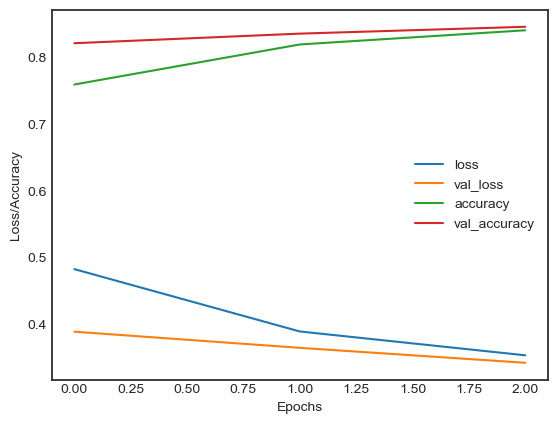

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend(['loss','val_loss','accuracy','val_accuracy'])
plt.show()

## Model Evaluation

In [57]:
input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []

# 평가데이터로 넣을 거 준비
for test_sentence, test_label in tqdm(zip(test_data['document'],
                                           test_data['label']),
                                           total= len(test_data)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(test_sentence, MAX_LEN) 
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        test_data_labels.append(test_label)
        
    except Exception as e:
        print(e)
        pass
test_input_ids = np.array(input_ids,dtype=int)
test_attention_masks = np.array(attention_masks,dtype=int)
test_token_type_ids = np.array(token_type_ids,dtype=int)
test_inputs = (test_input_ids, test_attention_masks, test_token_type_ids)  
test_data_labels = np.asarray(test_data_labels, dtype=np.int32)


100%|██████████████████████████████████████████████████████████████████████████| 49997/49997 [00:11<00:00, 4221.04it/s]


In [58]:
cls_model.evaluate(test_inputs, test_data_labels, batch_size=1024)

49/49 [==============================] - 3564s 73s/step - loss: 0.3502 - accuracy: 0.8425


[0.3502176105976105, 0.842490553855896]